In [1]:
import numpy as np
import xarray as xr
from xgcm import Grid
from matplotlib import pyplot as plt
import dask
import cmocean
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

%matplotlib inline

## Start cluster

In [2]:
from distributed import Client, progress, LocalCluster
import socket

client = Client(service_kwargs={'dashboard': {'prefix': f'/node/{socket.gethostname()}/8787'}})

In [3]:
client

Client Scheduler: tcp://127.0.0.1:39895 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 6 Cores: 24 Memory: 103.08 GB


In [4]:
#files = glob('/srv/scratch/z3533156/20year_run_tide/outer_dia/outer_dia_*.nc')
filelist=[]
for files in glob('/srv/scratch/z3533156/20year_run_tide/outer_dia/outer_dia_0[1-9]*.nc'): 
    #print(files)
    filelist.append(files)
#files = glob('/scratch/fu5/cgk561/eac/20year_freerun_NEW/output_heatbudget/outer_dia_01*.nc')
# A basic chunk choice
chunks = {'ocean_time':1}

diag = xr.open_mfdataset(filelist, chunks=chunks, data_vars='minimal',compat='override',coords='minimal',parallel=True)

#files = glob('/srv/scratch/z3533156/20year_run_tide/outer_avg/outer_avg_*.nc')
filelist=[]
for files in glob('/srv/scratch/z3533156/20year_run_tide/outer_avg/outer_avg_0[1-9]*.nc'): 
    #print(files)
    filelist.append(files)
#files = glob('/scratch/fu5/cgk561/eac/20year_freerun_NEW/output_heatbudget/outer_avg_01*.nc')

ds = xr.open_mfdataset(filelist, chunks=chunks, data_vars='minimal',compat='override',coords='minimal',parallel=True)

## Creating a grid object
While xgcm doesn't currently have an implementation for the SGRID convention for ROMS, a workaround consist on renaming eta_u and xi_v dimensions to rho. With this replacement 'psi' points have now a position (eta_v, xi_u). See issue here https://github.com/xgcm/xgcm/issues/108
Here I also test to see if the new XGCM 'metrics' functionality works.

In [5]:
# Including metrics
ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}}

grid = Grid(ds, coords=coords, periodic=[])

Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = Zo_rho * (ds.zeta + ds.h) + ds.zeta
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')


ds['pm_v'] = grid.interp(ds.pm, 'Y')
ds['pn_u'] = grid.interp(ds.pn, 'X')
ds['pm_u'] = grid.interp(ds.pm, 'X')
ds['pn_v'] = grid.interp(ds.pn, 'Y')
ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

ds['dx'] = 1/ds.pm
ds['dx_u'] = 1/ds.pm_u
ds['dx_v'] = 1/ds.pm_v
ds['dx_psi'] = 1/ds.pm_psi

ds['dy'] = 1/ds.pn
ds['dy_u'] = 1/ds.pn_u
ds['dy_v'] = 1/ds.pn_v
ds['dy_psi'] = 1/ds.pn_psi

ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
ds['dz_u'] = grid.interp(ds.dz, 'X')
ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
ds['dz_v'] = grid.interp(ds.dz, 'Y')
ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

ds['dA'] = ds.dx * ds.dy

metrics = {
    ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
    ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
    ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
    ('X', 'Y'): ['dA'] # Areas
}
grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

## Calculate depth-averaged speed

In [6]:
def magnitude(a, b):
    func = lambda x, y: np.sqrt(x ** 2 + y ** 2)
    return xr.apply_ufunc(func, a, b, dask="parallelized")

### need to interp ubar and vbar onto common locations

In [7]:
ubar_rho = grid.interp(ds.ubar,'X',boundary='fill')
vbar_rho = grid.interp(ds.vbar,'Y',boundary='fill')

In [8]:
ds['speed_bar'] = magnitude(ubar_rho,vbar_rho)

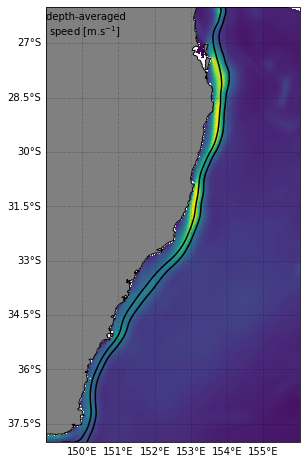

In [9]:
fig = plt.figure(figsize=(15,8))
#set coastline
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')

#plot
ax = plt.subplot(1,2,1,projection=ccrs.PlateCarree())
feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
im=ds.speed_bar.mean('ocean_time').plot.pcolormesh('lon_rho', 'lat_rho', ax=ax,add_colorbar=False)
ds.h.plot.contour('lon_rho', 'lat_rho', ax=ax, colors='black', levels=[200,1000])
ax.set_extent([149,156,-26,-38])
#make pretty gridlines and labels
gl = ax.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False

#label to tell what it is
plt.text(149,-26.8,'depth-averaged \n speed [m.s$^{-1}$]')
plt.savefig('Figures/speed_bar.png', dpi=300)

In [10]:
ds.speed_bar

<xarray.DataArray 'speed_bar' (ocean_time: 8308, eta_rho: 317, xi_rho: 272)>
dask.array<transpose, shape=(8308, 317, 272), dtype=float32, chunksize=(1, 315, 270), chunktype=numpy.ndarray>
Coordinates:
    lon_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    lat_rho     (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 1994-01-02 1994-01-03 ... 2016-09-30
Dimensions without coordinates: eta_rho, xi_rho